In [ ]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instedad
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on Graphs
This notebook shows how define and evaluate kernels on a simple graph.
By this we mean kernels $k: V \times V \to \mathbb{R}$ where $V$ is a vertex set of a graph.
The graph **must be** undirected and have nonnegative weights.
The edges of this graph define the geometry: you expect that nodes connected by edges with large weights to be more correlated than nodes connected by edges with small weights.

We use the **numpy** backend here.

**Important:** if you want to model a signal on the edges of a graph $G$, you can consider modeling the signal on the nodes of the [line graph](https://en.wikipedia.org/wiki/Line_graph). The line graph of $G$ has a node for each edge of $G$ and its two nodes are connected by an edge if the corresponding edges in $G$ used to share a common node. To build the line graph, you can use the [line_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.line.line_graph.html#line-graph) function of `networkx`.

In [3]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Graph
from geometric_kernels.kernels.geometric_kernels import MaternKarhunenLoeveKernel

# We use networkx to visualize graphs
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO: Using numpy backend


## Defining a Space

First we create and visualize a simple *star graph* using `networkx`

In [4]:
nx_graph = nx.star_graph(6)

Define graph layout to reuse it later on (so that graph appears the same on all pictures).

In [5]:
pos = nx.spring_layout(nx_graph)

Visualize the graph.

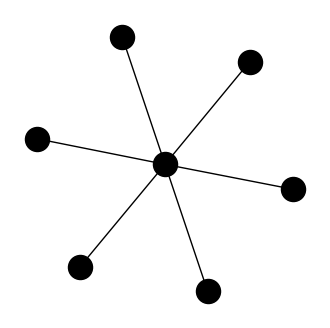

In [6]:
plt.figure(figsize=(4,4))
nx.draw(nx_graph, node_color = 'black', ax=plt.gca(), pos=pos)
plt.show()

The following cell turns the `nx_graph` created above into a GeometricKernels `Graph` space.

The `normalize_laplacian` parameter controls whether to use the eigenvectors
of the *unnormalized Laplacian* or the *symmetric normalized Laplacian* as
features (see the optional Theory section below for details).
You may want to try both `normalize_laplacian=False` and `normalize_laplacian=True` for your task.
The former is the default.

In [7]:
import lab as B

In [8]:
import plum
print(plum.__version__)

1.7.4


In [9]:
a = np.array([[1, 2], [3, 4]])
B.shape(a)

(2, 2)

In [10]:
G = Graph(np.array(nx.to_numpy_array(nx_graph)), normalize_laplacian=False)

## Theory (Optional Reading)
### General Theory Behind `MaternKarhunenLoeveKernel` for Graphs

Consider a (weighted) undirected graph with $N$ nodes determined by a (weighted) adjaceny matrix $\mathbf{A}$ of size $N \times N$.

Let $\mathbf{D}$ denote the degree matrix, i.e. the diagonal matrix with $\mathbf{D}_{j j} = \sum_{n=1}^N \mathbf{A}_{n j}$.
Then there are two notions of the *graph Laplacian* you can use to define kernels: the *unnormalized graph Laplacian* $\mathbf{\Delta}_{un} = \mathbf{D} - \mathbf{A}$ and the *symmetric normalized graph Laplacian* $\mathbf{\Delta}_{no} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}$ where $\mathbf{I}$ denotes the identity matrix.
Which one to use is up to the user, the performance will depend on the task at hand, in practice it makes sense to try both.

If $\mathbf{\Delta}$ is either $\mathbf{\Delta}_{un}$ or $\mathbf{\Delta}_{no}$, it is a symmetric postive semidefinite matrix.
Because of this, there is an orthonormal basis $\{\boldsymbol f_n\}_{n=1}^N$ in $\mathbb{R}^N$ of eigenvectors such that $\mathbf{\Delta} \boldsymbol f_n = \lambda_n \boldsymbol f_n$ for $0 = \lambda_1 \leq \lambda_2 \leq \ldots \leq \lambda_N$.

The eigenvectors $f_n$ can be regarded as functions on the graph nodes: $f_n(j) = (f_n)_j$.
In these terms, the `MaternKarhunenLoeveKernel` on the graph is then given by the formula
$$
k_{\nu, \kappa}(i,j)
=
\frac{1}{C_{\nu, \kappa}} \sum_{n=1}^L \Phi_{\nu, \kappa}(\lambda_n) f_n(i) f_n(j)
\qquad
\qquad
\Phi_{\nu, \kappa}(\lambda)
=
\begin{cases}
\left(\frac{2\nu}{\kappa^2} + \lambda\right)^{-\nu}
&
\nu < \infty \text{ — Matérn}
\\
e^{-\frac{\kappa^2}{2} \lambda}
&
\nu = \infty \text{ — Heat (RBF)}
\end{cases}
$$
The notation is as follows.
* $1 \leq L \leq N$ controls the quality of approximation of the kernel.
Setting $L = N$ gives you the exact kernel but usually requires $O(N^3)$ to compute the eigenpairs.
Setting $L \ll N$ can in principle allow much faster eigenpair computation for some graphs, such techniques are, however, not (yet) implemented in GeometricKernels.

* The constant $C_{\nu, \kappa}$ above ensures that average variance is equal to $1$, i.e. $\frac{1}{N} \sum_{n=1}^N k(n, n) = 1$.
It is easy to show that $C_{\nu, \kappa} = \sum_{n=1}^L \Phi_{\nu, \kappa}(\lambda_n)$.

**Note:** the "variance" $k(x, x)$ can vary from point to point.

**Note:** unlike the Euclidean or the manifold case, the $1/2, 3/2, 5/2$ may fail to be the reasonable values of $\nu$.
On the other hand, the parameter $\nu$ is optimizable in the same way in which the legnth scale is.
Keep in mind though, that the optimization problem may require finding some trial and error to find good a intitialization and that reasonable $\kappa$ and $\nu$ will heavily depend on the specific graph in a way that is hard to predict.

**Note:** consider $\mathbf{A}' = \alpha^2 \mathbf{A}$ for some $\alpha > 0$.
Then, for the normalized graph Laplacian $\mathbf{\Delta}_{no}$, we have $k_{\nu, \kappa}' (i, j) = k_{\nu, \kappa} (i, j)$ where $k_{\nu, \kappa}'$ is the kernel corresponding to $\mathbf{A}'$ instead of $\mathbf{A}$.
On the other hand, for the unnormalized graph Laplacian $\mathbf{\Delta}_{un}$, we have $k_{\nu, \kappa}' (i, j) = k_{\nu, \alpha \cdot \kappa} (i, j)$, i.e. the length scale changes.

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternKarhunenLoeveKernel`, you provide two parameters.
First, the `space`, in our case this is the `G` we have just created above.
The second parameter, `num_eigenfunctions`, determines the number of terms in the approximation of the kernel.
It should not exceed the number of vertices of the graph and it is recommented, unless you have a good reason not to, to set it to `G.num_vertices`.

**Note:** the `num_eigenlevels` parameter is equal to $L$ in terms of the theory above, it corresponds to the number of eigenpairs of the graph Laplacian used to approximate the kernel.

In [11]:
kernel = MaternKarhunenLoeveKernel(G, G.num_vertices)

To support JAX, our classes do not contain a *state*, it is external.
The next line initializes the *state* which is composed of two parts: `params`, a dictionary with kernel parameters, and `state`, a dictionary containing the eigenpairs.

`params` are initialized with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [12]:
params, state = kernel.init_params_and_state()
print('params:', params)
print('state:', state)

params: {'lengthscale': array(1.), 'nu': array(inf)}
state: {'eigenvalues_laplacian': array([[5.32907052e-15],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.00000000e+00]]), 'eigenfunctions': <geometric_kernels.spaces.base.ConvertEigenvectorsToEigenfunctions object at 0x7f18f81573a0>}


/home/vabor112/slava/workspace/ml/GeometricKernels/env/lib/python3.8/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [13]:
params["lengthscale"] = np.array([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `3` (uniformly) random points on our graph.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [14]:
key = np.random.RandomState(1234)

key, xs = G.random(key, 3)

print(xs)

[[3]
 [6]
 [5]]


Now we evaluate the two kernel matrices.

In [15]:
kernel_mat_32  = kernel.K(params_32,  state, xs, xs)
kernel_mat_inf = kernel.K(params_inf, state, xs, xs)

Finally, we visualize these matrices using `imshow`.

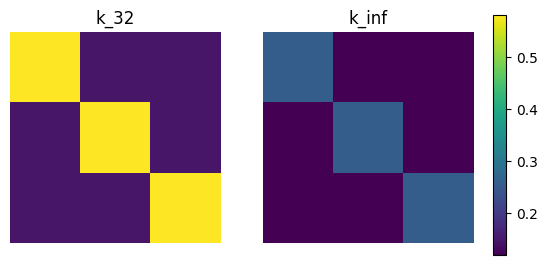

In [16]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Visualize Kernels

Here we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We define `base_point` and `other_points` in the next cell.

In [19]:
base_point = 1 # choosing a fixed node for kernel visualization
other_points = np.arange(G.num_vertices)[:, None]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [22]:
values_32  = np.asarray(kernel.K(params_32,  state, np.array([[base_point]]),
                              other_points)).flatten()
values_inf = np.asarray(kernel.K(params_inf, state, np.array([[base_point]]),
                              other_points)).flatten()

We also evaluate the variances $k_{\nu, \kappa}(x, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [23]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = np.asarray(kernel.K_diag(params_32,  state, other_points))
variance_inf = np.asarray(kernel.K_diag(params_inf, state, other_points))

Here are the actual visualization routines.

**Note:** the top right plot shows `k(base_point, *)` where `*` goes through all nodes and `base_point` has red outline. 

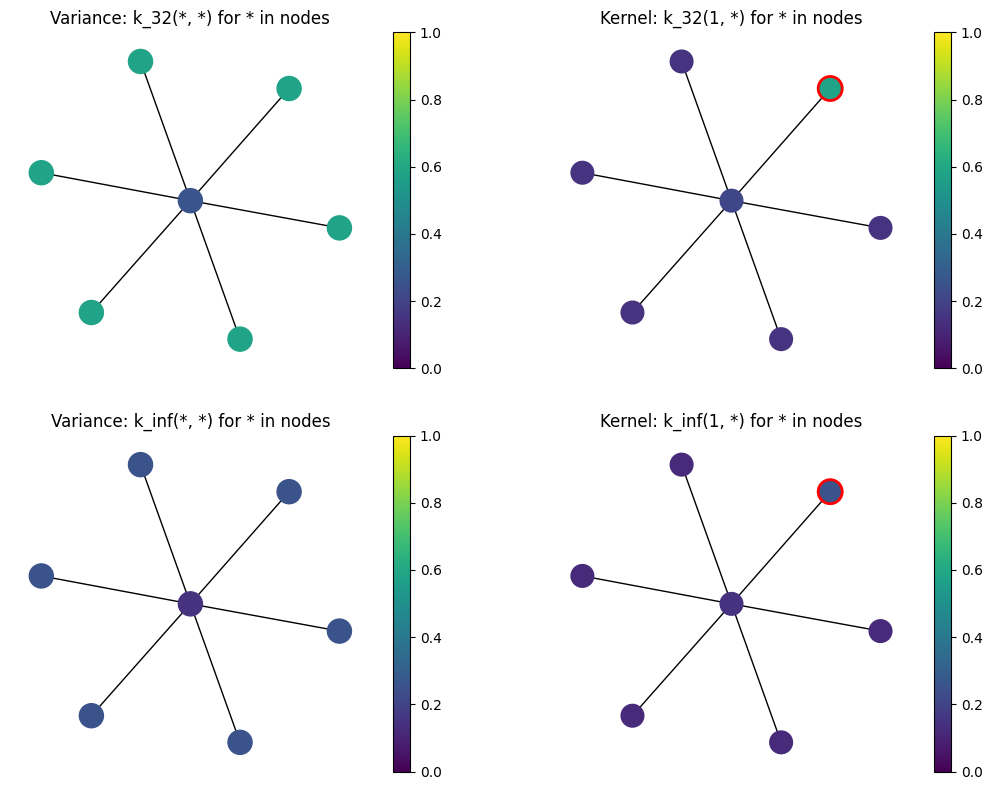

In [26]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
var_vmin = min(0.0, values_32.min(), values_inf.min())
var_vmax = max(1.0, variance_32.max(), variance_inf.max())
val_vmin, val_vmax = var_vmin, var_vmax


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*G.num_vertices
edgecolors[base_point] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.8, 9.6))

# Plot variance 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=variance_32,
        vmin=var_vmin, vmax=var_vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=var_vmin, vmax=var_vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Variance: k_32(*, *) for * in nodes')

# Plot kernel values 32
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_32,
        vmin=val_vmin, vmax=val_vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=val_vmin, vmax=val_vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: k_32(%d, *) for * in nodes' % base_point)

# Plot variance inf
nx.draw(nx_graph, ax=ax3, cmap=cmap, node_color=variance_inf,
        vmin=var_vmin, vmax=var_vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=var_vmin, vmax=var_vmax))
cbar = plt.colorbar(sm, ax=ax3)
ax3.set_title('Variance: k_inf(*, *) for * in nodes')

# Plot kernel values inf
nx.draw(nx_graph, ax=ax4, cmap=cmap, node_color=values_inf,
        vmin=val_vmin, vmax=val_vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=val_vmin, vmax=val_vmax))
cbar = plt.colorbar(sm, ax=ax4)
ax4.set_title('Kernel: k_inf(%d, *) for * in nodes' % base_point)


plt.show()

## A Note on Prior Variance

Note that the **variance changes from node to node** on this graph.

For example, for the **unnormalized Laplacian**, the variance is related to the expected *return time of a random walk*: how many steps, on average, does it take a particle
randomly walking over the graph and starting in node x to return back to node x.
For the center node, the expected return time is 2.
For other nodes, it is always higher.
Hence the variance in the center is *lower* than in the other nodes.

For the **symmetric normalized Laplacian** the sitation is different.

This argument is inspired by [Borovitskiy et al. (2021)](https://arxiv.org/pdf/2010.15538.pdf)
See this [Jupyter notebook](https://github.com/spbu-math-cs/Graph-Gaussian-Processes/blob/main/examples/graph_variance.ipynb) for more examples of how variance differs for different graphs.

In [29]:
print('Variance in the center node is %0.2f,' % variance_32[0],
      'variance in the side nodes is %0.2f.' % variance_32[1],
      'The average variance is %0.2f.' % np.mean(variance_32))

Variance in the center node is 0.26, variance in the side nodes is 0.58. The average variance is 0.54.
